In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from scipy import stats
from scipy.optimize import curve_fit

dat_path = os.getcwd()[:-12] + 'Data/'
fig_path = os.getcwd()[:-4] + 'figures/preliminary/SM/'
generated_dat_path = os.getcwd()[:-12] + 'Data/generated_data/'

text_font = 30

In [2]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def run_inflation():

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')


    fig, ax = plt.subplots(1,1, figsize=(8,5))

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    date_data = np.unique([x.year for x in odi_final['Match_Date']])

    tot_run_data, bat_run_data, bowl_run_data = [], [], []

    for year in np.unique(date_data):
        temp_df = odi_final[odi_final['Match_Date'].dt.year == year]
        
        tot_run_data.append(temp_df['Runs'].mean())

    #plot data only beyond 1975
    idx = np.where(date_data >= 1975)[0]

    date_data = np.array(date_data)[idx]
    tot_run_data = np.array(tot_run_data)[idx]

    coefficients = np.polyfit(date_data, tot_run_data, 1)
    regression_line = np.poly1d(coefficients)

    ax.plot(np.unique(date_data), tot_run_data, marker='o', linestyle=None, color = 'dodgerblue', markersize=10, linewidth=2.5)

    ax.plot(date_data, regression_line(date_data), '--', color= '#E34E29', linewidth = 4, zorder = 10)

    ax.set_xlabel(f'year',fontsize=text_font)
    ax.set_ylabel(f'team score', fontsize=text_font)

    axis_decor(ax, text_font, 12, 5, 2.5)
    
    # ax.legend(fontsize=text_font-5, loc='upper left')

    plt.tight_layout()
    plt.savefig(fig_path + f'run_inflation_over_years.pdf', format='pdf', dpi=300)

    plt.show()
    plt.close()

# run_inflation()

#### 0. Recurrence time distribution

In [5]:
def fit_(x_dat, y_dat):
    def exponential_func(x, a, b):
        return a * np.exp(-b * x)
        
    popt, pcov = curve_fit(exponential_func, x_dat, y_dat)

    return popt

In [6]:
def player_recurrence_data(norm_quant, min_career, category, perf_limit):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])
    
    player_list = odi_final['player_name'].unique()

    data_  = np.zeros((len(player_list), perf_limit))

    for pl, player in enumerate(tqdm(player_list)):
        player_df = odi_final[odi_final['player_name'] == player]

        if (category == 'batsmen') and (player_df['batsmen'].sum() > min_career):

            for perf in range(perf_limit):
                #binarise the performance
                temp_dat = np.where(player_df['renormalized_bat_run'] >= perf, 1, 0)

                #get the average distance between 1's
                avg_dist = np.mean(np.diff(np.where(temp_dat == 1)[0]))

                data_[pl, perf] = avg_dist

        elif (category == 'bowlers') and (player_df['bowler'].sum() > min_career):

            for perf in range(perf_limit):
                #binarise the performance
                temp_dat = np.where(player_df['bowl_wickets'] >= perf, 1, 0)

                #get the average distance between 1's
                avg_dist = np.mean(np.diff(np.where(temp_dat == 1)[0]))

                data_[pl, perf] = avg_dist

    data_ = data_[~np.all(data_ == 0, axis=1)]
    data_ = data_[:, ~np.all(data_ == 0, axis=0)]

    with open(generated_dat_path + f'player_recurrence_data_{category}_norm_quant_{norm_quant}_min_career_{min_career}_max_perf_{perf_limit}.pkl', 'wb') as f:
        pickle.dump(data_, f)

            
player_recurrence_data(norm_quant='Runs', min_career=25, category='batsmen', perf_limit=150)
player_recurrence_data(norm_quant='Runs', min_career=25, category='bowlers', perf_limit=10)

  0%|          | 0/2882 [00:00<?, ?it/s]/Users/onkar_mbp/miniconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/onkar_mbp/miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/2882 [00:00<?, ?it/s]/Users/onkar_mbp/miniconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/onkar_mbp/miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2882/2882 [00:18<00:00, 152.58it/s]


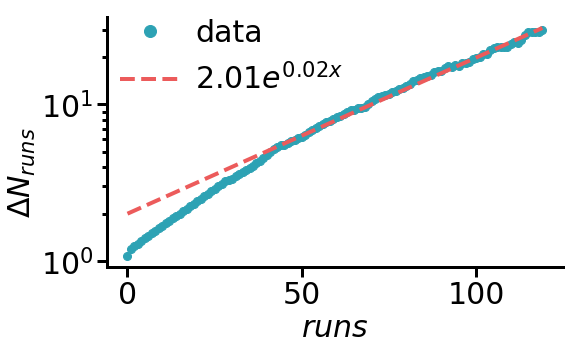

/var/folders/3d/0hpwl4kd1js9nrw8nl0qpc7m0000gn/T/ipykernel_6074/1278442694.py:8: RuntimeWarning: Mean of empty slice
  data_ = np.nanmean(data_, axis=0)


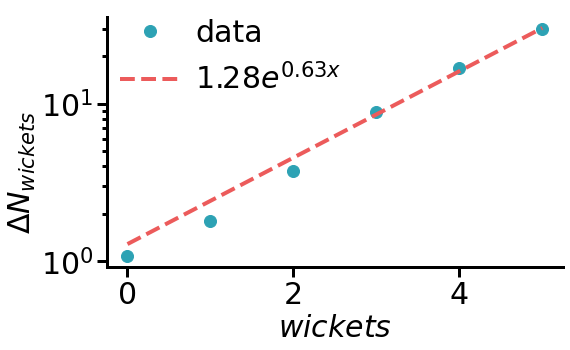

In [19]:
def player_recurrence_plot(norm_quant, min_career, category, perf_limit):

    with open(generated_dat_path + f'player_recurrence_data_{category}_norm_quant_{norm_quant}_min_career_{min_career}_max_perf_{perf_limit}.pkl', 'rb') as f:
        data_ = pickle.load(f)

    fig, ax = plt.subplots(figsize=(8,5))

    data_ = np.nanmean(data_, axis=0)

    if category == 'batsmen':
        ax.plot(data_[:120], marker='o', linestyle='none', markersize=8, color='#2DA2B4')
        ax.plot([], marker='o', linestyle='none', markersize=12, color='#2DA2B4', label='data')
        ax.set_xlabel(r'$runs$', fontsize=text_font)
        ax.set_ylabel(r'$\Delta N_{runs}$', fontsize=text_font)

        fit_params = fit_(range(120), data_[:120])
        x = range(120)
        y = fit_params[0] * np.exp(-fit_params[1] * x)
        plt.plot(x, y, color='#EC5B5B', linestyle='--', linewidth=4, label=rf'${fit_params[0]:.2f}e^{{{-fit_params[1]:.2f}x}}$')
    
    elif category == 'bowlers':
        ax.plot(data_[:6], marker='o', linestyle='none', markersize=12, color='#2DA2B4', label='data')
        ax.set_xlabel(r'$wickets$', fontsize=text_font)
        ax.set_ylabel(r'$\Delta N_{wickets}$', fontsize=text_font)


        fit_params = fit_(range(6), data_[:6])
        x = range(6)
        y = fit_params[0] * np.exp(-fit_params[1] * x)
        plt.plot(x, y, color='#EC5B5B', linestyle='--', linewidth=4, label=rf'${fit_params[0]:.2f}e^{{{-fit_params[1]:.2f}x}}$')

    ##shift y-axis label
    ax.yaxis.set_label_coords(-0.15, 0.38)

    ax.set_yscale('log')

    axis_decor(ax, text_font, 10, 5, 3)

    ax.legend(fontsize=text_font, loc='upper left',bbox_to_anchor=(-0.03, 0.9, 0.2, 0.2) ,frameon=False, handlelength=2, handletextpad=0.5, labelspacing=0.5)
    

    plt.tight_layout()
    plt.savefig(fig_path + f'player_recurrence_plot_{category}_norm_quant_{norm_quant}_min_career_{min_career}_max_perf_{perf_limit}.pdf', format='pdf', dpi=300)
    plt.show()


player_recurrence_plot(norm_quant='Runs', min_career=25, category='batsmen', perf_limit=150)
player_recurrence_plot(norm_quant='Runs', min_career=25, category='bowlers', perf_limit=10)

#### 1. predictors of performance: Q-model testing

In [8]:
def epoch_career_data(min_career, norm_quant, epoch, epoch_mode):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')
    player_name_list = odi_final['player_name'].unique()

    epoch_bat, full_bat = [], []
    epoch_bowl, full_bowl = [], []

    for player_name in tqdm(player_name_list):
        temp_player_df = odi_final[odi_final['player_name'] == player_name]
        temp_player_df = temp_player_df.sort_values(by='Match_ID')

        if len(temp_player_df['Match_ID'].unique()) >= epoch*2:

            if temp_player_df['batsmen'].sum() > min_career:
                if epoch_mode == 'late':
                    epoch_runs_mean = temp_player_df.iloc[-epoch:]['renormalized_bat_run'].dropna().mean()
                elif epoch_mode == 'random':
                    epoch_runs_mean = temp_player_df.iloc[np.random.randint(0, len(temp_player_df), epoch)]['renormalized_bat_run'].dropna().mean()
                elif epoch_mode == 'mid':
                    mid = len(temp_player_df)/2
                    epoch_runs_mean = temp_player_df.iloc[int(mid-epoch/2):int(mid+epoch/2)]['renormalized_bat_run'].dropna().mean()
        
                tot_runs_mean = temp_player_df['bat_run'].dropna().mean()

                if tot_runs_mean > epoch*0.25:
                    epoch_bat.append(epoch_runs_mean)
                    full_bat.append(tot_runs_mean)

            if temp_player_df['bowler'].sum() > min_career:
                if epoch_mode == 'late':
                    epoch_wickets_mean = temp_player_df.iloc[-epoch:]['bowl_wickets'].dropna().mean()
                elif epoch_mode == 'random':
                    epoch_wickets_mean = temp_player_df.iloc[np.random.randint(0, len(temp_player_df), epoch)]['bowl_wickets'].dropna().mean()
                elif epoch_mode == 'mid':
                    mid = len(temp_player_df)/2
                    epoch_wickets_mean = temp_player_df.iloc[int(mid-epoch/2):int(mid+epoch/2)]['bowl_wickets'].dropna().mean()

                tot_wickets_mean = temp_player_df['bowl_wickets'].dropna().mean()

                if tot_wickets_mean > epoch*0.00625:
                    epoch_bowl.append(epoch_wickets_mean)
                    full_bowl.append(tot_wickets_mean)

    with open(generated_dat_path + f'Q_model_and_career_performance_min_career_{min_career}_renorm_{norm_quant}_{epoch_mode}_{epoch}.pkl', 'wb') as f:
        pickle.dump([epoch_bat, full_bat, epoch_bowl, full_bowl], f)

# epoch_career_data(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='late')
# epoch_career_data(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='random')
# epoch_career_data(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='mid')

In [9]:
def epoch_career_plot(min_career, norm_quant, epoch, epoch_mode):

    with open(generated_dat_path + f'Q_model_and_career_performance_min_career_{min_career}_renorm_{norm_quant}_{epoch_mode}_{epoch}.pkl', 'rb') as f:
        early_bat, late_bat, early_bowl, late_bowl = pickle.load(f)

    for epoch_dat, late_dat, category, color in zip([early_bat, early_bowl], [late_bat, late_bowl], ['bat', 'bowl'], ['#6B967E', '#C56054']):

        fig, ax = plt.subplots(1,1, figsize=(5,5))

        epoch_dat = np.array(epoch_dat)
        late_dat = np.array(late_dat)

        ind = np.where(epoch_dat>0)[0]
        ax.scatter(epoch_dat[ind], late_dat[ind], color=color, s=70, alpha=0.85)
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(epoch_dat[ind], late_dat[ind])
        r_squared = r_value**2

        # Display R-squared value as text in the plot
        ax.text(0.5, 0.05, rf'$R^2$={r_squared:.2f}', transform=ax.transAxes, fontsize=text_font)

        print(f'{category} = ', np.count_nonzero(epoch_dat[ind] < late_dat[ind])/len(late_dat[ind]))

        
        if category == 'bat':
            ax.set_xticks([0, 20, 40], fontsize=text_font)
            ax.set_yticks([0, 20, 40], fontsize=text_font)

            x_dat = np.linspace(3, 52, 100)
            ax.plot(x_dat, x_dat, '--', color='black', linewidth=4, label='y=x')

            ax.set_xlabel(rf'{epoch_mode} career runs',fontsize=text_font)
            ax.set_ylabel(rf'full career runs', fontsize=text_font)

            ax.xaxis.set_label_coords(0.45, -0.2)
            ax.yaxis.set_label_coords(-0.22, 0.38)

            plt.ylim(bottom=0)
            plt.xlim(left=0)

            ax.legend(fontsize=text_font, loc='upper left', frameon=False, bbox_to_anchor=(-0.05, 0.9, 0.2, 0.2), labelspacing=0.1)
        
        elif category == 'bowl':
            ax.set_xticks([0, 1, 2], fontsize=text_font)
            ax.set_yticks([0, 1, 2], fontsize=text_font)

            x_dat = np.linspace(0.1, 2.2, 100)
            ax.plot(x_dat, x_dat, '--', color='black', linewidth=4)
            
            ax.set_xlabel(rf'{epoch_mode} career wickets',fontsize=text_font)
            ax.set_ylabel(rf'full career wickets', fontsize=text_font)

            #shift x and y axis labels
            ax.xaxis.set_label_coords(0.45, -0.2)
            ax.yaxis.set_label_coords(-0.15, 0.38)

            plt.ylim(bottom=0)
            plt.xlim(left=0)

        axis_decor(ax, text_font, 12, 5, 2.5)
        

        plt.tight_layout()
        plt.savefig(fig_path + f'Q_model_and_career_performance_{category}_min_career_{min_career}_renorm_{norm_quant}_{epoch_mode}_{epoch}.pdf', format='pdf', dpi=300)
        plt.show()
        plt.close()


# epoch_career_plot(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='late')
# epoch_career_plot(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='random')
# epoch_career_plot(min_career=25, norm_quant='Runs', epoch=25, epoch_mode='mid')

#### 2. survivors curve based on batting position

In [10]:
def batting_position_wise(min_career, norm_quant):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])
    odi_final = odi_final.sort_values(by=['Match_ID','Team'])


    odi_final = odi_final.groupby('player_name').filter(lambda x: len(x) >= min_career)

    runs_pos_wise = np.zeros(11)
    balls_pos_wise = np.zeros(11)

    runs_err = np.zeros(11)
    balls_err = np.zeros(11)

    for pos in range(11):
        temp_df = odi_final[odi_final['bat_pos'] == (pos+1)]
        runs_pos_wise[pos] = np.nanmean(temp_df['renormalized_bat_run'])
        balls_pos_wise[pos] = np.nanmean(temp_df['bat_balls'])

        runs_err[pos] = np.nanstd(temp_df['renormalized_bat_run'])/np.sqrt(len(temp_df))
        balls_err[pos] = np.nanstd(temp_df['bat_balls'])/np.sqrt(len(temp_df))

    with open(generated_dat_path + f'batting_position_wise_data_min_career_{min_career}_renorm_{norm_quant}.pkl', 'wb') as f:
        pickle.dump([runs_pos_wise, balls_pos_wise, runs_err, balls_err], f)


    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.errorbar(range(1, 12), runs_pos_wise, yerr=runs_err, linewidth = 3, marker='o', markersize=10, color='#23A9A8')
    ax2.errorbar(range(1, 12), balls_pos_wise, yerr=balls_err, linewidth = 3,  marker='s', markersize=10, color='#EFBA69')

    ax1.set_xlabel('batting position', fontsize=text_font)
    ax1.set_ylabel('runs', fontsize=text_font)
    ax2.set_ylabel('balls', fontsize=text_font, rotation=270, labelpad=30)

    ax1.set_xticks(range(1, 12))
    ax1.set_xticklabels(range(1, 12))


    ax1.plot([], [], linewidth = 3,  marker='s', markersize=10, label='runs', color='#23A9A8')
    ax1.plot([], [], linewidth = 3,  marker='s', markersize=10, label='balls', color='#EFBA69')
    ax1.legend(loc='upper right', fontsize=text_font, frameon=False, bbox_to_anchor=(0.25, 0.3, 0.2, 0.2), labelspacing=0.3, handletextpad=0.25, handlelength=2.5)


    axis_decor(ax1, text_font, 12, 5, 2.5)
    axis_decor(ax2, text_font, 12, 5, 2.5)
    ax1.spines['right'].set_linewidth(3)

    plt.tight_layout()
    plt.savefig(fig_path + f'batting_position_wise_min_career_{min_career}_renorm_{norm_quant}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# batting_position_wise(min_career=25, norm_quant='Runs')

#### 3. cross category contributions

In [11]:
def cross_category_data(min_career, norm_quant):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    players_list = np.unique(odi_final['player_name'])

    all_rounder_bat_contri, all_rounder_bowl_contri, batsman_bowl_contri, bowler_bat_contri = [], [], [], []

    for player in tqdm(players_list):
        player_df = odi_final[odi_final['player_name'] == player]

        if player_df['allrounder'].sum() >= min_career:
            for i in range(len(player_df)):
                
                if (player_df.iloc[i]['renormalized_runs'] > 0):
                    if(~np.isnan(player_df.iloc[i]['renormalized_bat_run'])):
                        all_rounder_bat_contri.append(0.5*(player_df.iloc[i]['renormalized_bat_run']/player_df.iloc[i]['renormalized_runs']))
                    else:
                        all_rounder_bat_contri.append(0)
                
                if (player_df.iloc[i]['opp_wickets'] > 0):
                    if(~np.isnan(player_df.iloc[i]['bowl_wickets'])):
                        all_rounder_bowl_contri.append(0.5*(player_df.iloc[i]['bowl_wickets']/player_df.iloc[i]['opp_wickets']))
                    else:
                        all_rounder_bowl_contri.append(0)


        elif player_df['bowler'].sum() >= min_career:
            for i in range(len(player_df)):
                if (player_df.iloc[i]['renormalized_runs'] > 0):
                    if (~np.isnan(player_df.iloc[i]['renormalized_bat_run'])):
                        bowler_bat_contri.append(0.5*(player_df.iloc[i]['renormalized_bat_run']/player_df.iloc[i]['renormalized_runs']))
                    else:
                        bowler_bat_contri.append(0)


        elif player_df['batsmen'].sum() >= min_career:
            for i in range(len(player_df)):
                if (player_df.iloc[i]['opp_wickets'] > 0):
                    if (~np.isnan(player_df.iloc[i]['bowl_wickets'])):
                        batsman_bowl_contri.append(0.5*(player_df.iloc[i]['bowl_wickets']/player_df.iloc[i]['opp_wickets']))
                    else:
                        batsman_bowl_contri.append(0)

                    if batsman_bowl_contri[-1] > 1:
                        print(player, player_df.iloc[i]['bowl_wickets'], player_df.iloc[i]['opp_wickets'])
                        break

    with open(generated_dat_path + f'cross_category_contribution_min_career_{min_career}_renorm_{norm_quant}.pkl', 'wb') as f:
        pickle.dump([all_rounder_bat_contri, all_rounder_bowl_contri, batsman_bowl_contri, bowler_bat_contri], f)

# cross_category_data(min_career=25, norm_quant='Runs')

In [12]:
def cross_category_plot(min_career, norm_quant):
    
    with open(generated_dat_path + f'cross_category_contribution_min_career_{min_career}_renorm_{norm_quant}.pkl', 'rb') as f:
        all_rounder_bat_contri, all_rounder_bowl_contri, batsman_bowl_contri, bowler_bat_contri = pickle.load(f)


    for category_dat, all_rounder_dat, color_list, category in zip([batsman_bowl_contri, bowler_bat_contri], [all_rounder_bowl_contri, all_rounder_bat_contri], [['#0EB6A2', '#07574E'], ['#F0B253', '#EE6542']], ['wickets', 'runs']):

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        category_dat = np.array(category_dat)
        all_rounder_dat = np.array(all_rounder_dat)


        ax.scatter(all_rounder_dat, np.random.uniform(0,1, len(all_rounder_dat)), color=color_list[0], s=70, alpha=0.3, marker='o')
        ax.scatter(category_dat, np.random.uniform(2,3, len(category_dat)), color=color_list[1], s=70, alpha=0.3, marker='o')

        ax.vlines(np.nanmean(all_rounder_dat), -0.3, 1.3, color='black', linewidth=4, linestyle='-')
        ax.vlines(np.nanmean(category_dat), 1.7, 3.3, color='black', linewidth=4, linestyle='-')

        print(np.nanmean(all_rounder_dat), np.nanmean(category_dat))

        ax.text(0.54, 0.3, f'all-rounder {category}', fontsize=text_font)
        if category == 'wickets':
            ax.text(0.54, 2.2, 'batsmen wickets', fontsize=text_font)
        elif category == 'runs':
            ax.text(0.54, 2.2, 'bowler runs', fontsize=text_font)

    
        ax.set_ylim(-0.5, 3.5)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.spines['bottom'].set_bounds(0,1)

        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)

        ax.set_xlabel(rf'fractional contribution, $f_c$', fontsize=text_font+5)

        axis_decor(ax, text_font, 10, 5, 3)

        plt.tight_layout()
        plt.savefig(fig_path + f'cross_category_{category}_contribution_min_career_{min_career}_renorm_{norm_quant}.png', format='png', dpi=200)
        plt.show()
        plt.close()

# cross_category_plot(min_career=25, norm_quant='Runs')

#### 4. captainship duration

In [13]:
def captainship_duration_data(min_career, norm_quant, min_captain):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'])

    captain_bat, captain_bowl = [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')

        if temp_df['batsmen'].sum() > min_career:
            if temp_df['captain'].sum() > min_captain:
                captain_bat.append(len(temp_df))

        if temp_df['bowler'].sum() > min_career:
            if temp_df['captain'].sum() > min_captain:
                captain_bowl.append(len(temp_df))


    with open(generated_dat_path + f'captain_duration_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.pkl', 'wb') as f:
        pickle.dump([captain_bat, captain_bowl], f)

# captainship_duration_data(min_career=25, norm_quant='Runs', min_captain=50)

In [14]:
def captainship_duration_plot(min_career, norm_quant, min_captain):

    with open(generated_dat_path + f'captain_duration_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.pkl', 'rb') as f:
        captain_bat, captain_bowl = pickle.load(f)


    # Set the figure size
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the histograms
    ax.hist(captain_bat, bins=7, alpha=0.5, color='#23A9A8', label='batsmen')
    ax.hist(captain_bowl, bins=7, alpha=0.5, color='#FA485B', label='bowler')

    # mean v-lines
    ax.vlines(np.mean(captain_bat), 0, 11, color='#23A9A8', linewidth=4, linestyle='--')
    ax.vlines(np.mean(captain_bowl), 0, 11, color='#FA485B', linewidth=4, linestyle='--')

    print(np.mean(captain_bat), np.mean(captain_bowl))

    # Add labels and titles
    ax.set_xlabel('Captainship Duration', fontsize=text_font)
    ax.set_ylabel('Frequency', fontsize=text_font)


    axis_decor(ax, text_font, 10, 5, 2.5)

    # Add legend
    ax.legend(fontsize=text_font, loc='upper right', frameon=False, bbox_to_anchor=(0.9, 0.9, 0.2, 0.2), labelspacing=0.1)

    plt.tight_layout()
    plt.savefig(fig_path + f'captainship_duration_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# captainship_duration_plot(min_career=25, norm_quant='Runs', min_captain=50)

#### 5. best individual performance in a match

In [15]:
def best_perform(df):
    # Sort by the first column in descending order, then by the second column in ascending order
    df = df.sort_values(by=[df.columns[0], df.columns[1]], ascending=[False, True])
    
    indices = df.index.tolist()

    #make sure the array is of length 11, by adding the remaining indices from 1 to 11
    if len(indices) < 11:
        for i in range(len(indices), 12):
            if i not in indices:
                indices.insert(i-1, i)
                break
    
    return indices

In [16]:
def individual_team_contribution_data(norm_quant, abs_rel):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    match_num_list = np.unique(odi_final['Match_ID'])

    len_streak = 11

    win_bat, win_bowl = [[] for x in range(len_streak)], [[] for x in range(len_streak)]
    loss_bat, loss_bowl = [[] for x in range(len_streak)], [[] for x in range(len_streak)]

    for match_num in tqdm(match_num_list):

        match_df = odi_final[odi_final['Match_ID'] == match_num]

        team_list = np.unique(match_df['Team'])

        team1_df = match_df[match_df['Team'] == team_list[0]]
        team1_df = team1_df.reset_index(drop=True)

        team2_df = match_df[match_df['Team'] == team_list[1]]
        team2_df = team2_df.reset_index(drop=True)


        for team_df in  [team1_df, team2_df]:
            
            #change all nan values to zero
            team_df = team_df.fillna(0)

            if team_df.iloc[0]['Team'] == team_df.iloc[0]['Winner']:

                best_bat = best_perform(team_df[['renormalized_bat_run', 'bat_balls']])

                if np.sum(team_df['renormalized_bat_run']) != 0:
                    
                    if abs_rel:
                        for l in range(len_streak):
                            win_bat[l].append((team_df.iloc[best_bat[l]]['renormalized_bat_run'])/(np.sum(team_df['renormalized_bat_run'])))
                    else:
                        for l in range(len_streak):
                            win_bat[l].append((team_df.iloc[best_bat[l]]['renormalized_bat_run']))

                ############################

                best_bowl = best_perform(team_df[['bowl_wickets', 'bowl_runs']])
                
                if (np.sum(team_df['bowl_wickets'])) != 0:
                    if abs_rel:
                        for l in range(len_streak):
                            win_bowl[l].append((team_df.iloc[best_bowl[l]]['bowl_wickets'])/(np.sum(team_df['bowl_wickets'])))
                    else:
                        for l in range(len_streak):
                            win_bowl[l].append((team_df.iloc[best_bowl[l]]['bowl_wickets']))
            
            
            ################
            ############################
            ################
            
            else:

                best_bat = best_perform(team_df[['renormalized_bat_run', 'bat_balls']])

                if np.sum(team_df['renormalized_bat_run']) != 0:
                    if abs_rel:
                        for l in range(len_streak):
                            loss_bat[l].append((team_df.iloc[best_bat[l]]['renormalized_bat_run'])/(np.sum(team_df['renormalized_bat_run'])))
                    else:
                        for l in range(len_streak):
                            loss_bat[l].append((team_df.iloc[best_bat[l]]['renormalized_bat_run']))

                ############################
                best_bowl = best_perform(team_df[['bowl_wickets', 'bowl_runs']])

                if (np.sum(team_df['bowl_wickets'])) != 0:
                    if abs_rel:
                        for l in range(len_streak):
                            loss_bowl[l].append((team_df.iloc[best_bowl[l]]['bowl_wickets'])/(np.sum(team_df['bowl_wickets'])))
                    else:
                        for l in range(len_streak):
                            loss_bowl[l].append((team_df.iloc[best_bowl[l]]['bowl_wickets']))


    with open(generated_dat_path + f'best_individual_team_contribution_renorm_{norm_quant}_abs_{abs_rel}.pkl', 'wb') as f:
        pickle.dump([win_bat, win_bowl, loss_bat, loss_bowl], f)

# individual_team_contribution_data(norm_quant='Runs', abs_rel=True)
# individual_team_contribution_data(norm_quant='Runs', abs_rel=False)

In [17]:
def individual_team_contribution_plot(norm_quant, abs_rel):

    len_streak = 11

    with open(generated_dat_path + f'best_individual_team_contribution_renorm_{norm_quant}_abs_{abs_rel}.pkl', 'rb') as f:
        win_bat, win_bowl, loss_bat, loss_bowl = pickle.load(f)

    fig, ax = plt.subplots(1,2,figsize=(15, 5))
    ax = ax.flatten()

    box_colors = ['#F2B141','#717A6E']


    ax[0].plot(np.arange(1, len_streak+1), np.nanmean(win_bat, axis=1), color=box_colors[0], linewidth=3, marker='o', markersize=10, label='win')
    ax[0].plot(np.arange(1, len_streak+1), np.nanmean(loss_bat, axis=1), color=box_colors[1], linewidth=3, marker='o', markersize=10, label='loss')
    # ax[0].text(0.5, 0.4, 'batting', fontsize=text_font+5, transform=ax[0].transAxes)

        
    ax[1].plot(np.arange(1, len_streak+1), np.nanmean(win_bowl, axis=1),color=box_colors[0], linewidth=3, marker='o', markersize=10, label='win')
    ax[1].plot(np.arange(1, len_streak+1), np.nanmean(loss_bowl, axis=1), color=box_colors[1], linewidth=3, marker='o', markersize=10, label='loss')
    # ax[1].text(0.5, 0.4, 'bowling', fontsize=text_font+5, transform=ax[1].transAxes)

    
    for axes, category in zip(ax, ['runs', 'wickets']):
        axis_decor(axes, text_font+3, 10, 5, 2)
        axes.set_xticks([1, 6, 11], fontsize=text_font)

        axes.set_xlabel('performance rank', fontsize=text_font)
        axes.set_ylabel('contribution', fontsize=text_font)
        if abs_rel:
            axes.set_ylabel(f'{category} (relative) ', fontsize=text_font)
        else:
            axes.set_ylabel(category, fontsize=text_font)


    ax[0].legend(loc='upper right', fontsize=text_font+5, frameon=False, bbox_to_anchor=(0.8,0.8,0.2, 0.2), ncol=2, labelspacing=1, columnspacing=0.8, handletextpad=0.25, handlelength=1.3)

    plt.tight_layout()
    plt.savefig(fig_path + f'individual_team_contribution_renorm_{norm_quant}_abs_{abs_rel}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()


# individual_team_contribution_plot(norm_quant='Runs', abs_rel=True)
# individual_team_contribution_plot(norm_quant='Runs', abs_rel=False)